In [12]:

from pandas import read_csv

from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns 
import xgboost as xgb
from xgboost import XGBClassifier
import csv
import pandas as pd
from scipy.stats import pearsonr 
import numpy as np
from sklearn.model_selection import cross_val_score
from scipy.stats import pointbiserialr
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from certifi import where
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import VotingClassifier
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn.preprocessing import StandardScaler

In [ ]:
#讀檔案
filename_train= 'train.csv'
filename_test= 'X_test.csv'
df_train= pd.read_csv(filename_train)
df_test= pd.read_csv(filename_test)

y_train = df_train['D_isR']
df_train = df_train.drop(columns=['D_isR'])

# data preprocessing（e.g. 離群值、低變異欄位、負值、空值、標準化等等）
df_train['D_Dbuild'] = df_train['D_Dbuild'].apply(lambda x: max(0, x))

positive_values = df_train[(df_train['D_Dbuild'] > 0) & (df_train['D_Dbuild'] <= 2023)]['D_Dbuild']
mean_value = int(positive_values.mean())
df_train['D_Dbuild'] = df_train['D_Dbuild'].apply(lambda x: mean_value if x > 2023 else x)

df_train.iloc[:, 1:16] = df_train.iloc[:, 1:16].clip(0, 1)

positive_values = df_train[(df_train.iloc[:, 16] > 0) & (df_train.iloc[:, 16] < 10)].iloc[:, 16]
mean_value = int(positive_values.mean())
df_train.iloc[:, 16] = df_train.iloc[:, 16].apply(lambda x: mean_value if x > 10 or x <= 0 or pd.isna(x) else x)
 
columns_to_update = ['D_1floorCorridorCol', 'D_1floorClassCol', 'D_1floorInsideCol']
for column_name in columns_to_update:
    
    mean_value = df_train[column_name][df_train[column_name] >= 0][df_train[column_name] < 100].mean()
    df_train[column_name] = df_train[column_name].apply(lambda x: mean_value if x >= 100 else x)

columns_to_update = ['D_Demand', 'D_Tx', 'D_sds']
for column_name in columns_to_update:
    
    mean_value = df_train[column_name][df_train[column_name] >= 0][df_train[column_name] < 5].mean()
    df_train[column_name] = df_train[column_name].apply(lambda x: mean_value if x >= 5 else x)

columns_to_update = [43, 44, 45, 46, 47]
for column_index in columns_to_update:
    
    positive_int_values = df_train.iloc[:, column_index][df_train.iloc[:, column_index] >= 0][df_train.iloc[:, column_index] < 100]
    integer_mean = int(positive_int_values.mean())
    df_train.iloc[:, column_index] = df_train.iloc[:, column_index].apply(lambda x: integer_mean if x >= 100 else x)

positive_int_values = df_train['D_basintype'][(df_train['D_basintype'] >= 0) & (df_train['D_basintype'] < 10)]
integer_mean = int(positive_int_values.mean())
df_train['D_basintype'] = df_train['D_basintype'].apply(lambda x: integer_mean if x >= 10 else x)

positive_values = df_train['D_475Acc'][df_train['D_475Acc'] >= 0][df_train['D_475Acc'] < 1]
mean_value = positive_values.mean()
df_train['D_475Acc'] = df_train['D_475Acc'].apply(lambda x: mean_value if x >= 1 else x)


df_train= df_train.fillna(0)
df_test= df_test.fillna(0)

df_train.iloc[:, 17:59] = df_train.iloc[:, 17:59].applymap(lambda x: 0 if x < 0 else x)


threshold = 0.6
columns_to_check = list(range(17, 30)) + list(range(32, 39)) + list(range(47, 49)) + list(range(51, 58))
columns_to_delete = []
for column in columns_to_check:
    mean_value = df_train.iloc[:, column].mean()
    std_dev = df_train.iloc[:, column].std()
    coefficient_of_variation = std_dev / mean_value
    if coefficient_of_variation < threshold:
        columns_to_delete.append(df_train.columns[column])
df_train = df_train.drop(columns=columns_to_delete)
df_test = df_test.drop(columns=columns_to_delete)
print("已刪除的欄位名稱：", columns_to_delete)

columns_to_drop = ['D_sms', 'D_sm1', 'D_tm0', 'D_Ra_Capacity', 'D_Ra_CDR','D_StructureSystem_Brick_wall_with_Wooden_pillar'
                   ,'D_StructureSystem_Wood_or_Synthetic_Resins','D_StructureSystem_NaN','D_475Acc','D_structure_1','D_structure_3']
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)


count_enc = ce.CountEncoder(cols=['D_basintype', 'D_nonstructure'])
count_enc.fit(df_train[['D_basintype', 'D_nonstructure']])
df_train_encoded = count_enc.transform(df_train[['D_basintype', 'D_nonstructure']])
df_test_encoded = count_enc.transform(df_test[['D_basintype', 'D_nonstructure']])
df_train[['D_basintype', 'D_nonstructure']] = df_train_encoded
df_test[['D_basintype', 'D_nonstructure']] = df_test_encoded


columns_with_negative_values = df_train.columns[(df_train < 0).any()]
print("存在負數的欄位：", columns_with_negative_values)

# 再將資料分成 X_train, X_test, Y_train陣列
X_train = df_train.values
y_train = y_train.values
X_test = df_test.values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# 對資料進行標準化
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

X_test_std = scaler.transform(X_test)

In [7]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_std, y_train, test_size=0.2, random_state=42)
# 創建 SMOTE 過採樣
over = SMOTE(sampling_strategy=0.9, random_state=1008, k_neighbors=5)
# RandomUnderSampler 欠採樣
under = RandomUnderSampler(sampling_strategy=0.95, random_state=1008)
#採樣步驟
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# 進行採樣
X_train_resampled, y_train_resampled = pipeline.fit_resample(X_train_split, y_train_split)
counter = Counter(y_train_resampled)
print(counter)

Counter({1: 2017, 0: 1917})


In [ ]:
params = {
    'reg_alpha':[0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.05]  

}
Grid_xgb = GridSearchCV(XGBClassifier(scoring='auc',n_estimators=800,max_depth=7,learning_rate=0.2,subsample=0.7
                                      ,colsample_bytree=0.7,gamma=0.15),
                                      param_grid=params,n_jobs=-1,cv=5)
Grid_xgb.fit(X_train_resampled,y_train_resampled)

means = Grid_xgb.cv_results_['mean_test_score']
params = Grid_xgb.cv_results_['params']
print('best score and params:',Grid_xgb.best_score_,Grid_xgb.best_params_)

In [8]:
# 37個XGBoost分類器 gridsearch結果 
xgb_models = []
for i in range(37):
    xgb_model = XGBClassifier(
        n_estimators=1000,  
        learning_rate=0.05, 
        max_depth=6,  
        subsample=0.8,  
        colsample_bytree=0.8, 
        gamma=0.2, 
        reg_alpha=0.02, 
        objective='binary:logistic', 
        random_state=i  
    )
    xgb_models.append(('xgb{}'.format(i), xgb_model))

# 投票分類器
voting_model_2 = VotingClassifier(estimators=xgb_models, voting='soft')

voting_model_2.fit(X_train_resampled, y_train_resampled)
# 預測
y_pred = voting_model_2.predict(X_test_std)

In [289]:
# 保存預測結果
csv_file_name = 'r11525138_submission.csv'
with open(csv_file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id", "label"])
    for i, pred_label in enumerate(y_pred):
        writer.writerow([i+1, pred_label])

Precision: 0.8220064724919094
Recall: 0.951310861423221
F1 Score: 0.8819444444444444


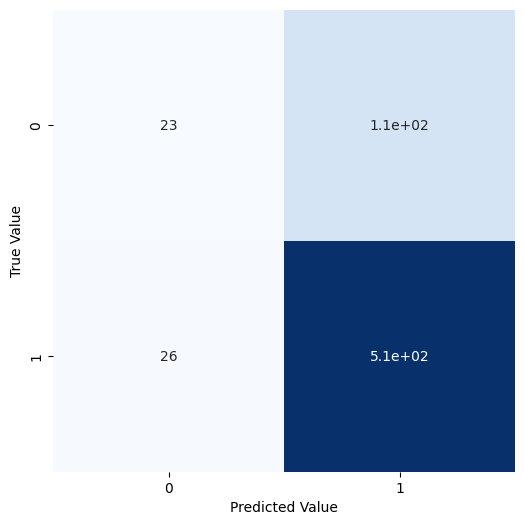

In [9]:
# confusion matrix
y_preds = voting_model_2.predict(X_val_split)
confusion = confusion_matrix(y_val_split, y_preds)


precision = precision_score(y_val_split, y_preds)
recall = recall_score(y_val_split, y_preds)
f1_score =  2 * ((recall * precision) / (recall + precision))
print("Precision:", precision) #300:0.816  350:0.8163   sub/colsample0.8:0.8199
print("Recall:", recall)  # 300:0.9719   350:0.9737    sub/colsample0.8:0.9719
print("F1 Score:", f1_score)  #300:0.887  350:0.888   sub/colsample0.8:0.889

plt.figure(figsize=(6, 6))
sns.heatmap(confusion, square= True, annot=True, cbar= False, cmap='Blues')
plt.xlabel("Predicted Value")
plt.ylabel("True Value")
plt.show()

##### 100%train gridsearch


In [ ]:
filename_train= 'train.csv'
filename_test= 'X_test.csv'
df_train= pd.read_csv(filename_train)
df_test= pd.read_csv(filename_test)

y_train = df_train['D_isR']
df_train = df_train.drop(columns=['D_isR'])

df_train['D_Dbuild'] = df_train['D_Dbuild'].apply(lambda x: max(0, x))

positive_values = df_train[(df_train['D_Dbuild'] > 0) & (df_train['D_Dbuild'] <= 2023)]['D_Dbuild']
mean_value = int(positive_values.mean())
df_train['D_Dbuild'] = df_train['D_Dbuild'].apply(lambda x: mean_value if x > 2023 else x)

df_train.iloc[:, 1:16] = df_train.iloc[:, 1:16].clip(0, 1)

positive_values = df_train[(df_train.iloc[:, 16] > 0) & (df_train.iloc[:, 16] < 10)].iloc[:, 16]
mean_value = int(positive_values.mean())
df_train.iloc[:, 16] = df_train.iloc[:, 16].apply(lambda x: mean_value if x > 10 or x <= 0 or pd.isna(x) else x)
#  TVX
columns_to_update = ['D_1floorCorridorCol', 'D_1floorClassCol', 'D_1floorInsideCol']
for column_name in columns_to_update:
    
    mean_value = df_train[column_name][df_train[column_name] >= 0][df_train[column_name] < 100].mean()
    df_train[column_name] = df_train[column_name].apply(lambda x: mean_value if x >= 100 else x)
# AH AI AK
columns_to_update = ['D_Demand', 'D_Tx', 'D_sds']
for column_name in columns_to_update:
    
    mean_value = df_train[column_name][df_train[column_name] >= 0][df_train[column_name] < 5].mean()
    df_train[column_name] = df_train[column_name].apply(lambda x: mean_value if x >= 5 else x)
# AR-AU
columns_to_update = [43, 44, 45, 46, 47]
for column_index in columns_to_update:
   
    positive_int_values = df_train.iloc[:, column_index][df_train.iloc[:, column_index] >= 0][df_train.iloc[:, column_index] < 100]
    integer_mean = int(positive_int_values.mean())
    df_train.iloc[:, column_index] = df_train.iloc[:, column_index].apply(lambda x: integer_mean if x >= 100 else x)
# AE
positive_int_values = df_train['D_basintype'][(df_train['D_basintype'] >= 0) & (df_train['D_basintype'] < 10)]
integer_mean = int(positive_int_values.mean())
df_train['D_basintype'] = df_train['D_basintype'].apply(lambda x: integer_mean if x >= 10 else x)
# AF
positive_values = df_train['D_475Acc'][df_train['D_475Acc'] >= 0][df_train['D_475Acc'] < 1]
mean_value = positive_values.mean()
df_train['D_475Acc'] = df_train['D_475Acc'].apply(lambda x: mean_value if x >= 1 else x)

df_train= df_train.fillna(0)
df_test= df_test.fillna(0)

df_train.iloc[:, 17:59] = df_train.iloc[:, 17:59].applymap(lambda x: 0 if x < 0 else x)

threshold = 0.6
columns_to_check = list(range(17, 30)) + list(range(32, 39)) + list(range(47, 49)) + list(range(51, 58))
columns_to_delete = []
for column in columns_to_check:
    mean_value = df_train.iloc[:, column].mean()
    std_dev = df_train.iloc[:, column].std()
    coefficient_of_variation = std_dev / mean_value
    if coefficient_of_variation < threshold:
        columns_to_delete.append(df_train.columns[column])
df_train = df_train.drop(columns=columns_to_delete)
df_test = df_test.drop(columns=columns_to_delete)
print("已刪除的欄位名稱：", columns_to_delete)

columns_to_drop = ['D_sms', 'D_sm1', 'D_tm0', 'D_Ra_Capacity', 'D_Ra_CDR','D_StructureSystem_Brick_wall_with_Wooden_pillar'
                   ,'D_StructureSystem_Wood_or_Synthetic_Resins','D_StructureSystem_NaN','D_475Acc','D_structure_1','D_structure_3']
df_train = df_train.drop(columns=columns_to_drop)
df_test = df_test.drop(columns=columns_to_drop)


count_enc = ce.CountEncoder(cols=['D_basintype', 'D_nonstructure'])
count_enc.fit(df_train[['D_basintype', 'D_nonstructure']])
df_train_encoded = count_enc.transform(df_train[['D_basintype', 'D_nonstructure']])
df_test_encoded = count_enc.transform(df_test[['D_basintype', 'D_nonstructure']])
df_train[['D_basintype', 'D_nonstructure']] = df_train_encoded
df_test[['D_basintype', 'D_nonstructure']] = df_test_encoded


columns_with_negative_values = df_train.columns[(df_train < 0).any()]
print("存在負數值的欄位：", columns_with_negative_values)

X_train = df_train.values
y_train = y_train.values
X_test = df_test.values

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

X_test_std = scaler.transform(X_test)


In [ ]:
over = SMOTE(sampling_strategy=0.9, random_state=1008, k_neighbors=5)
under = RandomUnderSampler(sampling_strategy=0.95, random_state=1008)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
X_train_std_resampled, y_train_std_resampled = pipeline.fit_resample(X_train_std, y_train)
counter = Counter(y_train_std_resampled)
print(counter)

In [ ]:
params = {
   'reg_alpha':[0.01,0.015,0.02,0.025,0.03,0.035,0.04,0.05] 

}
Grid_xgb = GridSearchCV(XGBClassifier(scoring='auc',max_depth=7,n_estimators=350,learning_rate=0.04
                                      ,gamma=0.2,subsample=0.8,colsample_bytree=0.35),
                                      param_grid=params,n_jobs=-1,cv=5)
Grid_xgb.fit(X_train_std_resampled,y_train_std_resampled)

means = Grid_xgb.cv_results_['mean_test_score']
params = Grid_xgb.cv_results_['params']
print('best score and params:',Grid_xgb.best_score_,Grid_xgb.best_params_)

In [354]:
# 37個XGBoost分類器 gridsearch結果 
xgb_models = []
for i in range(37):
    xgb_model = XGBClassifier(
        n_estimators=1000,  
        learning_rate=0.05,  
        max_depth=6,  
        subsample=0.8,  
        colsample_bytree=0.8,  
        gamma=0.2, 
        reg_alpha=0.02,  
        objective='binary:logistic', 
        random_state=i  
    )
    xgb_models.append(('xgb{}'.format(i), xgb_model))


voting_model_2 = VotingClassifier(estimators=xgb_models, voting='soft')

voting_model_2.fit(X_train_std_resampled, y_train_std_resampled)

y_pred = voting_model_2.predict(X_test_std)

In [355]:
csv_file_name = 'r11525138_submission.csv'
with open(csv_file_name, 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["id", "label"])
    for i, pred_label in enumerate(y_pred):
        writer.writerow([i+1, pred_label])